# Downscaling Windspeed for the **Manhattan** area

**Variables:**
* Variable to be downscaled: Wind Speed (WS)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 3451.3 km²

In [25]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [9]:
!python --version

Python 3.8.18


# Retrieve files from server

In [10]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/wind-NYC-split/train/uWRF_final_01-02.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/wind-NYC-split/val/uWRF_final_03.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/wind-NYC-split/test/uWRF_final_03.nc')

nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/WS-NYC-data/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/home/gvaillant1/downscaling/data/WS-NYC-data/aligned_nam_val_data.nc')
nam_test = xr.open_dataset('/home/gvaillant1/downscaling/data/WS-NYC-data/aligned_nam_test_data.nc')

# Calculating Spatial Coverage:

In [24]:
import xarray as xr
import numpy as np
from geopy.distance import geodesic

# Load the dataset
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/wind-NYC-split/train/uWRF_final_01-02.nc')

# Extract latitude and longitude
lat = uwrf_train['latitude'].values  # Assuming 'latitude' is the name of the dimension
lon = uwrf_train['longitude'].values  # Assuming 'longitude' is the name of the dimension

# Compute the distance between two adjacent latitude points (in km)
lat_diff = np.abs(lat[1] - lat[0])  # Difference between two adjacent latitude points
lat_distance_km = lat_diff * 111  # 1 degree of latitude ~ 111 km

# Compute the distance between two adjacent longitude points (in km)
lon_diff = np.abs(lon[1] - lon[0])  # Difference between two adjacent longitude points
lon_distance_km = lon_diff * 111 * np.cos(np.radians(lat[0]))  # Adjust for latitude

# Calculate the area of one grid cell (in km²)
cell_area_km2 = lat_distance_km * lon_distance_km

# Calculate the total area covered by the dataset (in km²)
num_lat_cells = len(lat)
num_lon_cells = len(lon)
total_area_km2 = num_lat_cells * num_lon_cells * cell_area_km2

# Output the total area
print(f"Total area covered by the dataset: {total_area_km2} km²")


Total area covered by the dataset: 3451.2937839810534 km²


# Accessing specific variable from each dataset

In [11]:
#High resolution (uWRF) data
WS_hr_train = uwrf_train.WS
WS_hr_val = uwrf_val.WS
WS_hr_test = uwrf_test.WS

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC

#--------------------------
#Low resolution (NAM) data
WS_lr_train = nam_train.WS
WS_lr_val = nam_val.WS
WS_lr_test = nam_test.WS

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Normalization

In [12]:
WS_scaler_train = dds.StandardScaler(axis=None)
WS_scaler_train.fit(WS_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = WS_scaler_train.transform(WS_hr_train)
y_val = WS_scaler_train.transform(WS_hr_val)
y_test = WS_scaler_train.transform(WS_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = WS_scaler_train.transform(WS_lr_train)
x_val = WS_scaler_train.transform(WS_lr_val)
x_test = WS_scaler_train.transform(WS_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)

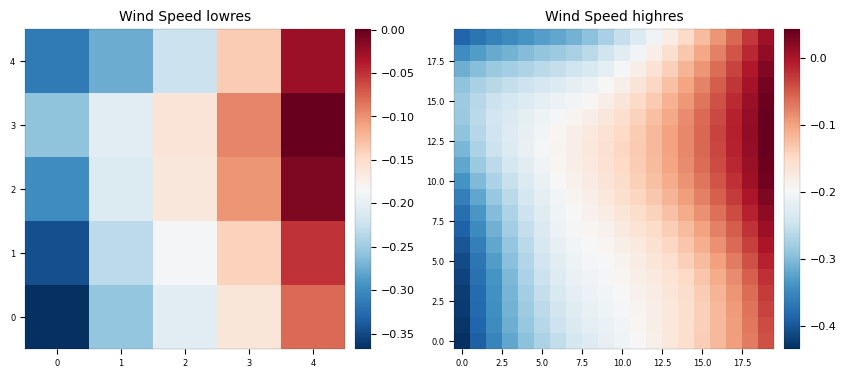

In [13]:
ecv.plot((x_train[0].values, y_train[0]), subplot_titles=('Wind Speed lowres', 'Wind Speed highres'))

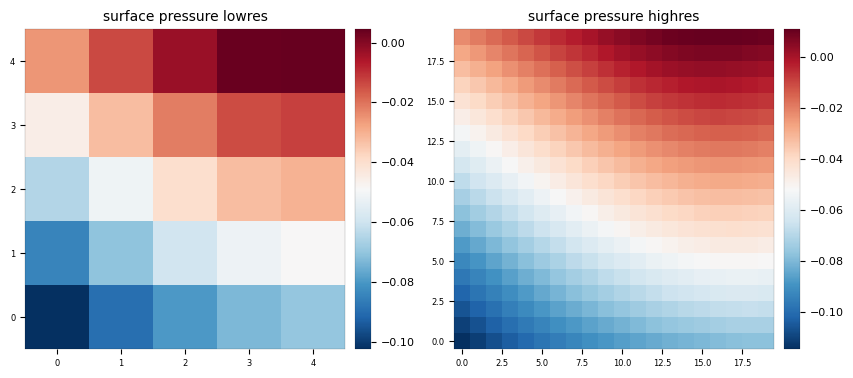

In [14]:
ecv.plot((x_z_train[0].values, y_z_train[0]), subplot_titles=('surface pressure lowres', 'surface pressure highres'))

In [15]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

In [16]:
print("Wind Speed hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("Wind Speed lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

Wind Speed hr data shape:
(1537, 20, 20, 1) (899, 20, 20, 1) (899, 20, 20, 1)

PSFC hr data shape:
(1537, 20, 20, 1) (899, 20, 20, 1) (899, 20, 20, 1)

Wind Speed lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)

PSFC lr data shape:
(1537, 5, 5, 1) (449, 5, 5, 1) (450, 5, 5, 1)


HR array: (20, 20, 1), LR array (5, 5, 2)


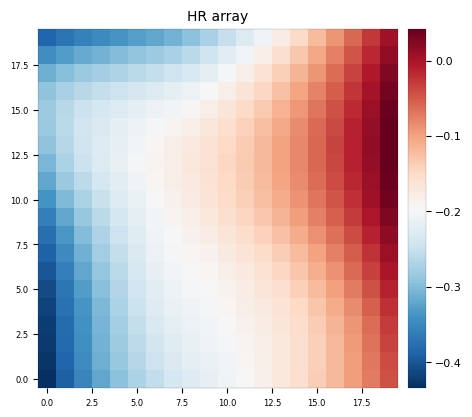

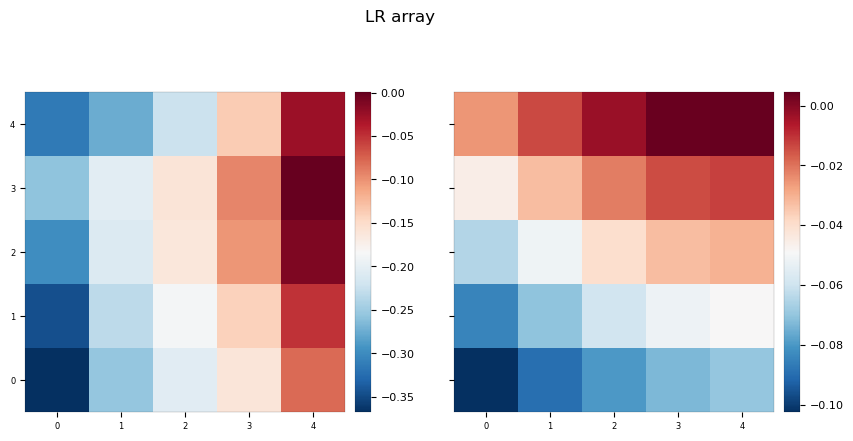

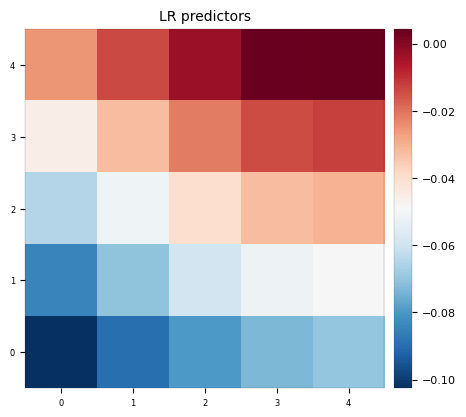

In [17]:
#Check for correct creation of the low-res version of uWRF
#This function is called before training begins. This is just an example to show what is going on:

_ = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

In [18]:
ARCH_PARAMS = dict(n_filters=20,
                   n_blocks=4,
                   normalization=None,
                   dropout_rate=0.5,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=False)

trainer = dds.SupervisedTrainer(
    backbone='densenet',
    upsampling='spc', 
    data_train=y_train,
    data_val=y_val,
    data_test=y_test,
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4, 
    time_window=None, 
    static_vars=None,
    predictors_train=[y_z_train],
    predictors_val=[y_z_val],
    predictors_test=[y_z_test],
    interpolation='inter_area',
    patch_size=None, 
    batch_size=60,
    loss='mae',
    epochs=50, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=False, patience=6, min_delta=0, 
    save=False, 
    save_path=None,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)
trainer.run()

List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-01-15 16:25:44
--------------------------------------------------------------------------------
Model: "densenet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_1 (InputLayer)                        [(None, None, None, 2)]                      0              []                                           
                                                                                                                                                      
 conv2d (Conv2D)                             (None

In [19]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=[y_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=60,
    scaler=WS_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-15 16:26:59
--------------------------------------------------------------------------------
15/15 [==============================] - 0s 14ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:00.520366
--------------------------------------------------------------------------------


In [20]:
pred1 = dds.Predictor(
    trainer, 
    x_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=[x_z_train], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=60,
    scaler=WS_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-01-15 16:26:59
--------------------------------------------------------------------------------
26/26 [==============================] - 0s 14ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:00.493443
--------------------------------------------------------------------------------


In [ ]:
unscaled_y_test = WS_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_y_test[0].values, unscaled_y_pred[0]), subplot_titles=('groundtruth WS', 'downscaled WS'))

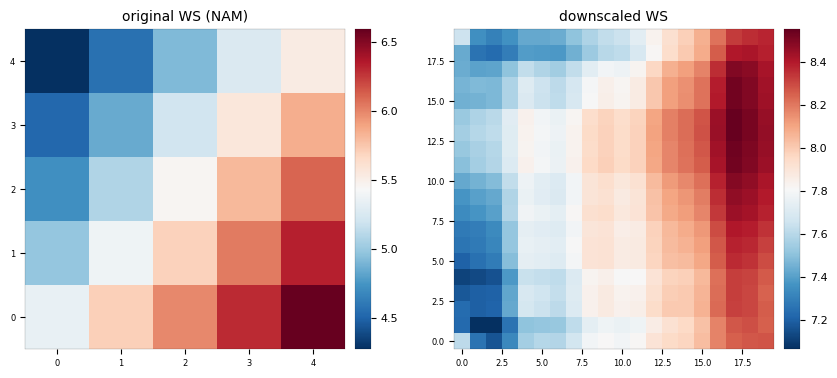

In [22]:
unscaled_x_test = WS_scaler_train.inverse_transform(x_test)
unscaled_x_train = WS_scaler_train.inverse_transform(x_train)
ecv.plot((unscaled_x_test[0].values, unscaled_x_pred[0]), subplot_titles=('original WS (NAM)', 'downscaled WS'))

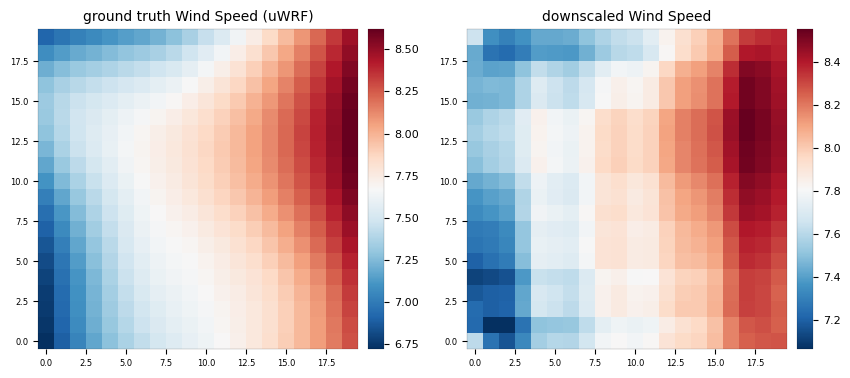

In [23]:
unscaled_y_train = WS_scaler_train.inverse_transform(y_train)
ecv.plot((unscaled_y_train[0].values, unscaled_x_pred[0]), subplot_titles=('ground truth Wind Speed (uWRF)', 'downscaled Wind Speed'))